# Project 2
## EDA

In [323]:
#read in imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

## Load the Data

In [324]:
#change the name of the df from 'Train' in data cleaning to 'ames' so as not to be confused when splitting the data
ames = pd.read_csv('datasets/clean.csv')
ames.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,533352170,60,RL,75.0,13517,0,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,531379050,60,RL,43.0,11492,0,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,535304180,20,RL,68.0,7922,0,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,916386060,60,RL,73.0,9802,0,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,906425045,50,RL,82.0,14235,0,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


## Feature Engineering

### Explore non-numeric features

The below cell is a function used on dataframe columns that contain 'object' types. It is a work in progress and is commented out in order to not throw errors in this notebook. 

In [325]:
# # create Object class handler function, returns the average of the value counts of the given feature 
# #functionality and looping was aided and enhanced by Noelle Brown
# def object_handler(df, object_class, target, tolerance):
#     from scipy import stats
#     means = []
#     values = df[object_class].value_counts().index

#     internal_count = 0

#     for j in range(len(values)):
#         master_count = 0
#         column_target = df[df[object_class] == values[j]][target]
#         internal_count +=1
#         comparison_counter = 0
#         for k in range(internal_count,len(values)):
#             column = df[df[object_class] == values[k]][target]
#             tt = stats.ttest_ind(column_target, column, equal_var = False)
            
# #            print('stat',tt.statistic)
#             print('pvalue',tt.pvalue)
#             comparison_counter += 1
#             if tt.pvalue < 0.05:
#                 master_count += 1
#         print('---')                      
#         if master_count / comparison_counter >= tolerance : #opportunities
#              print(object_class, 'is significant to the model')
# #             print(values[j], 'sig')
#          else:
#             print('failed')
# # #            print(object_class, 'is not significant to the model')
# #             print(values[j])


# # created nested loop to check the p-value of mean vs mean for each lement, count the number of 
# #significant observations, if the total is larger than 50% of the observations, the elements are 
# #statisticlly signiicant

# ## Conduct our t-test.
# #tt = stats.ttest_ind(trt, ctrl, equal_var = False)
# #tt.pvalue

In [326]:
#object_handler(ames,'MS Zoning','SalePrice',.5)

In [327]:
ames['MS Zoning'].value_counts()

RL         1596
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MS Zoning, dtype: int64

In [328]:
# filter by data type 'object' 
ames.select_dtypes(include=['object']).info()

#code adapted from documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 40 columns):
MS Zoning         2049 non-null object
Lot Shape         2049 non-null object
Land Contour      2049 non-null object
Utilities         2049 non-null object
Lot Config        2049 non-null object
Land Slope        2049 non-null object
Neighborhood      2049 non-null object
Condition 1       2049 non-null object
Condition 2       2049 non-null object
Bldg Type         2049 non-null object
House Style       2049 non-null object
Roof Style        2049 non-null object
Roof Matl         2049 non-null object
Exterior 1st      2049 non-null object
Exterior 2nd      2049 non-null object
Mas Vnr Type      2049 non-null object
Exter Qual        2049 non-null object
Exter Cond        2049 non-null object
Foundation        2049 non-null object
Bsmt Qual         1994 non-null object
Bsmt Cond         1994 non-null object
Bsmt Exposure     1994 non-null object
BsmtFin Type 1    1994 non-null obj

**Based on industry knowledge of how these features influence home prices the following features will be examined further: 
'MS Zoning' , 'Neighborhood' , 'Condition 1' , 'Condition 2' , 'Bldg Type' , 'House Style' , 'Kitchen Qual'** <br>
<br>
Using the object_handler() funtion, all of the 'object' features will be evaluated.

In [329]:
#assign the 'object' type features as a list so they can be itterated over.
objects = ames.select_dtypes(include=['object']).columns

Check for feature significance. <br>
This means for every feature, 99% of the feature's value's mean 'saleprice' are significantly different from one another. <br>
The tolerance was set so high to reduce the amount of features in the model.

In [330]:
# # itterate over each feature using the a 99% requirement
# for i in range(len(objects)):
#     feature = objects[i]
#     object_handler(ames, feature, 'SalePrice', 0.99)

In [331]:
neighborhood_df = pd.get_dummies(ames, columns = ['Neighborhood'])
neighborhood_names = neighborhood_df.columns[-28:]
neighborhood_names = list(neighborhood_names)
neighborhood_names.append('SalePrice')

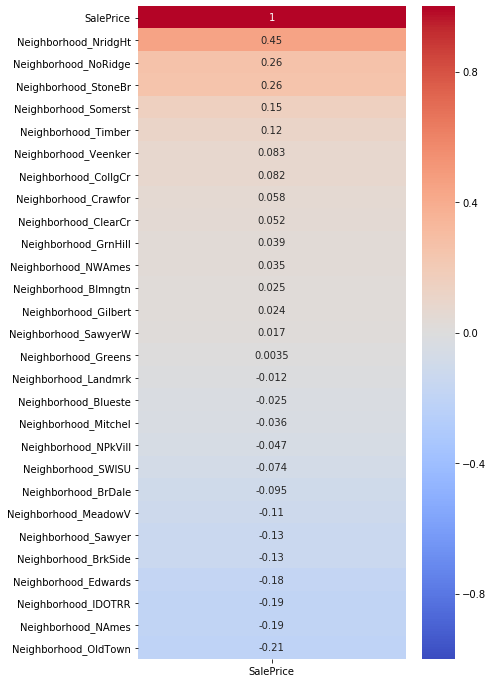

In [332]:
neighborhood_corr = neighborhood_df[neighborhood_names].corr()[['SalePrice']].sort_values(['SalePrice'],
                                                                                          ascending = False)
plt.figure(figsize = (6,12))
sns.heatmap(neighborhood_corr, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)

In [333]:
ames['MS Zoning'].value_counts()

RL         1596
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MS Zoning, dtype: int64

In [334]:
ms_zoning_df = pd.get_dummies(ames,columns = ['MS Zoning'])
ms_zoning_names = list(ms_zoning_df.columns[-7:])
ms_zoning_names.append('SalePrice')

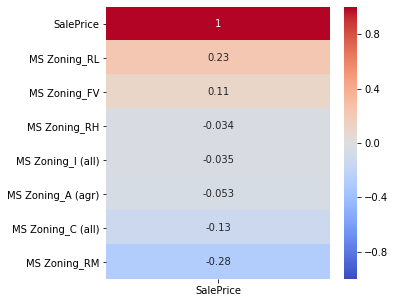

In [335]:
ms_zoning_corr = ms_zoning_df[ms_zoning_names].corr()[['SalePrice']].sort_values(['SalePrice'],
                                                                                          ascending = False)
plt.figure(figsize = (5,5))
sns.heatmap(ms_zoning_corr, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)

In [336]:
ames['Condition 1'].value_counts()

Norm      1766
Feedr      108
Artery      70
RRAn        36
PosN        27
RRAe        21
PosA        12
RRNn         6
RRNe         3
Name: Condition 1, dtype: int64

In [337]:
condition_df = pd.get_dummies(ames,columns = ['Condition 1'])
condition_names = list(condition_df.columns[-9:])
condition_names.append('SalePrice')

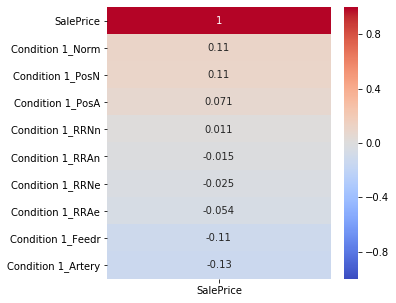

In [338]:
condition_corr = condition_df[condition_names].corr()[['SalePrice']].sort_values(['SalePrice'],
                                                                                          ascending = False)
plt.figure(figsize = (5,5))
sns.heatmap(condition_corr, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)

In [339]:
ames['Bldg Type'].value_counts()

1Fam      1698
TwnhsE     161
Duplex      75
Twnhs       69
2fmCon      46
Name: Bldg Type, dtype: int64

In [340]:
type_df = pd.get_dummies(ames, columns = ['Bldg Type'])
type_names = list(type_df.columns[-5:])
type_names.append('SalePrice')

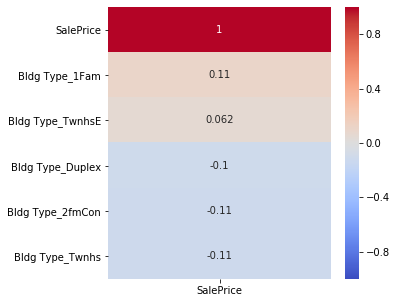

In [341]:
type_corr = type_df[type_names].corr()[['SalePrice']].sort_values(['SalePrice'],
                                                                                          ascending = False)
plt.figure(figsize = (5,5))
sns.heatmap(type_corr, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)

In [342]:
ames['House Style'].value_counts()

1Story    1058
2Story     597
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: House Style, dtype: int64

In [343]:
style_df = pd.get_dummies(ames, columns = ['House Style'])
style_names = list(style_df.columns[-8:])
style_names.append('SalePrice')

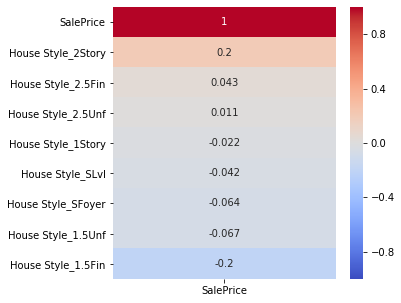

In [344]:
style_corr = style_df[style_names].corr()[['SalePrice']].sort_values(['SalePrice'],
                                                                                          ascending = False)
plt.figure(figsize = (5,5))
sns.heatmap(style_corr, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)

In [345]:
ames['Kitchen Qual'].value_counts()

TA    1047
Gd     806
Ex     149
Fa      47
Name: Kitchen Qual, dtype: int64

In [346]:
kitchen_df = pd.get_dummies(ames, columns = ['Kitchen Qual'])
kitchen_names = list(kitchen_df.columns[-4:])
kitchen_names.append('SalePrice')

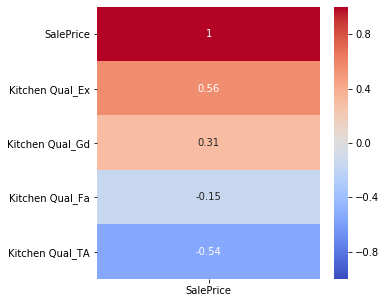

In [347]:
kitchen_corr = kitchen_df[kitchen_names].corr()[['SalePrice']].sort_values(['SalePrice'],
                                                                                          ascending = False)
plt.figure(figsize = (5,5))
sns.heatmap(kitchen_corr, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)

In [348]:
ames['Bsmt Qual'].value_counts()

TA    887
Gd    864
Ex    182
Fa     60
Po      1
Name: Bsmt Qual, dtype: int64

In [349]:
bsmt_qual_df = pd.get_dummies(ames, columns = ['Bsmt Qual'])
bsmt_qual_names = list(bsmt_qual_df.columns[-5:])
bsmt_qual_names.append('SalePrice')

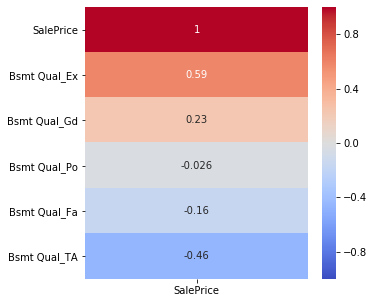

In [350]:
bsmt_qual_corr = bsmt_qual_df[bsmt_qual_names].corr()[['SalePrice']].sort_values(['SalePrice'],
                                                                                          ascending = False)
plt.figure(figsize = (5,5))
sns.heatmap(bsmt_qual_corr, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)

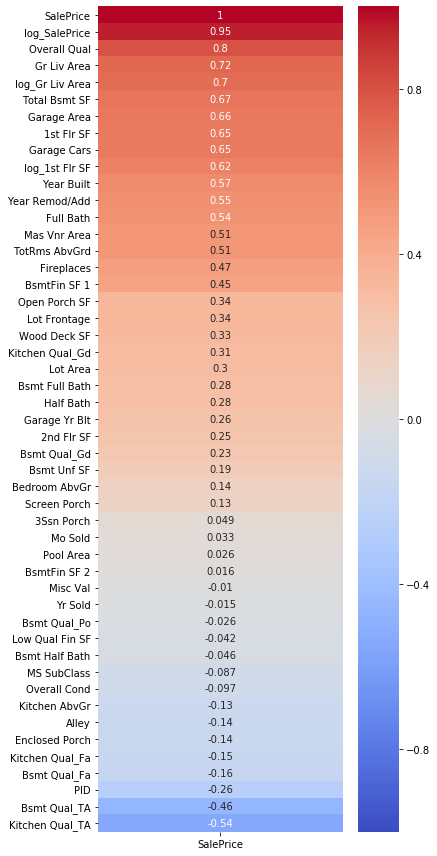

In [382]:
# heatmap based on target 'price' to pick high correlation predictors
price_corr = ames.corr()[['SalePrice']].sort_values(['SalePrice'],ascending = False)

plt.figure(figsize = (6,12))
sns.heatmap(price_corr, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)
plt.tight_layout()

#save this image
plt.savefig('./images/feature_corr_heatmap.png')

# .tight_layout() code taken from: https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib

In [352]:
#create 'predictors list' based on any column with greater than + 0.5 correllation to price (not including 'SalePrice')
predictors = price_corr[price_corr['SalePrice'] >= -0.3].index
predictors = predictors[1:]
predictors

Index(['Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', 'Garage Area',
       '1st Flr SF', 'Garage Cars', 'Year Built', 'Year Remod/Add',
       'Full Bath', 'Mas Vnr Area', 'TotRms AbvGrd', 'Fireplaces',
       'BsmtFin SF 1', 'Open Porch SF', 'Lot Frontage', 'Wood Deck SF',
       'Lot Area', 'Bsmt Full Bath', 'Half Bath', 'Garage Yr Blt',
       '2nd Flr SF', 'Bsmt Unf SF', 'Bedroom AbvGr', 'Screen Porch',
       '3Ssn Porch', 'Mo Sold', 'Pool Area', 'BsmtFin SF 2', 'Misc Val',
       'Yr Sold', 'Low Qual Fin SF', 'Bsmt Half Bath', 'MS SubClass',
       'Overall Cond', 'Kitchen AbvGr', 'Alley', 'Enclosed Porch', 'PID'],
      dtype='object')

In [353]:
predictors_low = price_corr[price_corr['SalePrice'] < -.1].index
predictors_low = predictors_low[1:]
predictors_low

Index(['Alley', 'Enclosed Porch', 'PID'], dtype='object')

The distribution of 'SalePrice', '1st Flr SF', 'Gr Liv Area', 'Mas Vnr Area' are all left skewed. The model will change these to the logarithmic scale and then convert 'SalePrice' back to the standard scale for the prediction.

In [354]:
#convert 'SalePrice', '1st Flr SF', 'Gr Liv Area', 'Mas Vnr Area' to logarithmic
ames['log_SalePrice'] = np.log(ames['SalePrice'])
ames['log_1st Flr SF'] = np.log(ames['1st Flr SF'])
ames['log_Gr Liv Area'] = np.log(ames['Gr Liv Area'])
#throwing a log(0) error
#ames['log_Mas Vnr Area'] = np.log(ames['Mas Vnr Area'])

In [355]:
#change from pd index to list 
predictors = list(predictors)
#remove unwanted list items '1st Flr SF', 'Gr Liv Area'
predictors.remove('Gr Liv Area')
predictors.remove('1st Flr SF')

In [356]:
predictors_low = list(predictors_low)
predictors_low

['Alley', 'Enclosed Porch', 'PID']

In [357]:
#check to ensure list changes
predictors

['Overall Qual',
 'Total Bsmt SF',
 'Garage Area',
 'Garage Cars',
 'Year Built',
 'Year Remod/Add',
 'Full Bath',
 'Mas Vnr Area',
 'TotRms AbvGrd',
 'Fireplaces',
 'BsmtFin SF 1',
 'Open Porch SF',
 'Lot Frontage',
 'Wood Deck SF',
 'Lot Area',
 'Bsmt Full Bath',
 'Half Bath',
 'Garage Yr Blt',
 '2nd Flr SF',
 'Bsmt Unf SF',
 'Bedroom AbvGr',
 'Screen Porch',
 '3Ssn Porch',
 'Mo Sold',
 'Pool Area',
 'BsmtFin SF 2',
 'Misc Val',
 'Yr Sold',
 'Low Qual Fin SF',
 'Bsmt Half Bath',
 'MS SubClass',
 'Overall Cond',
 'Kitchen AbvGr',
 'Alley',
 'Enclosed Porch',
 'PID']

In [358]:
#add 'log_1st Flr SF' and 'log_Gr Liv Area' to list
predictors.append('log_1st Flr SF')
predictors.append('log_Gr Liv Area')

In [359]:
for i in range(len(predictors_low)):
    predictors.append(predictors_low[i])
#check list
predictors

['Overall Qual',
 'Total Bsmt SF',
 'Garage Area',
 'Garage Cars',
 'Year Built',
 'Year Remod/Add',
 'Full Bath',
 'Mas Vnr Area',
 'TotRms AbvGrd',
 'Fireplaces',
 'BsmtFin SF 1',
 'Open Porch SF',
 'Lot Frontage',
 'Wood Deck SF',
 'Lot Area',
 'Bsmt Full Bath',
 'Half Bath',
 'Garage Yr Blt',
 '2nd Flr SF',
 'Bsmt Unf SF',
 'Bedroom AbvGr',
 'Screen Porch',
 '3Ssn Porch',
 'Mo Sold',
 'Pool Area',
 'BsmtFin SF 2',
 'Misc Val',
 'Yr Sold',
 'Low Qual Fin SF',
 'Bsmt Half Bath',
 'MS SubClass',
 'Overall Cond',
 'Kitchen AbvGr',
 'Alley',
 'Enclosed Porch',
 'PID',
 'log_1st Flr SF',
 'log_Gr Liv Area',
 'Alley',
 'Enclosed Porch',
 'PID']

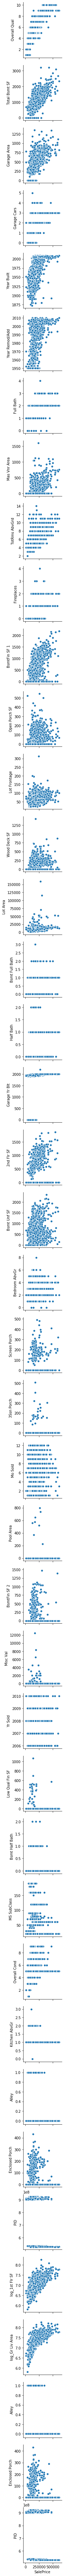

In [360]:
#use pairplot to check linearity of predictors to 'price'
sns.pairplot(ames, x_vars=['SalePrice'], y_vars= predictors)


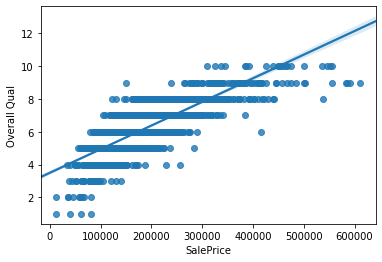

In [361]:
sns.regplot(y='Overall Qual', x='SalePrice', data=ames);

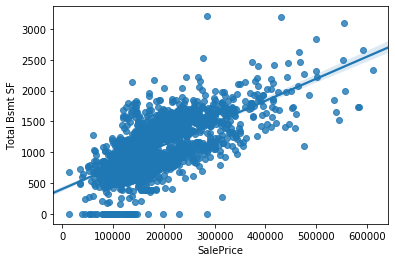

In [362]:
sns.regplot(y='Total Bsmt SF', x='SalePrice', data=ames);

### Investigate the relationship between SalePrice, log_SalePrice, Gr Liv Area, and log_Gr Liv Area

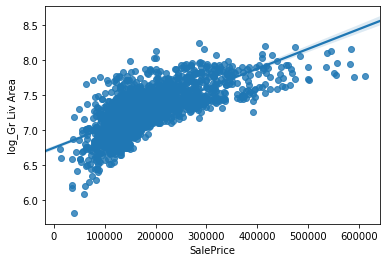

In [363]:
sns.regplot(y='log_Gr Liv Area', x='SalePrice', data=ames);

#the seaborn regression plot taken from documentation: https://seaborn.pydata.org/tutorial/regression.html

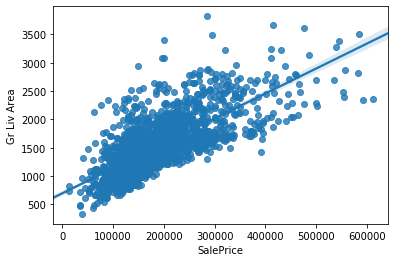

In [364]:
sns.regplot(y='Gr Liv Area', x='SalePrice', data=ames);

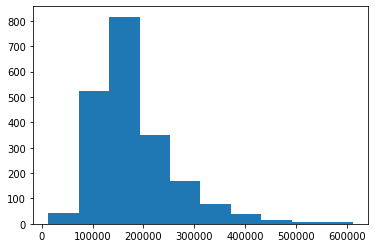

In [365]:
plt.hist(ames['SalePrice']);

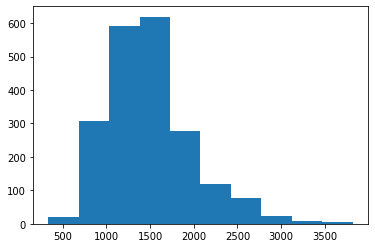

In [366]:
plt.hist(ames['Gr Liv Area']);

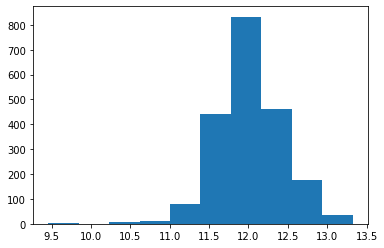

In [367]:
plt.hist(ames['log_SalePrice']);

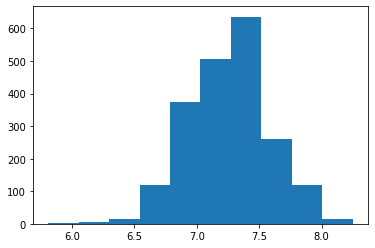

In [368]:
plt.hist(ames['log_Gr Liv Area']);

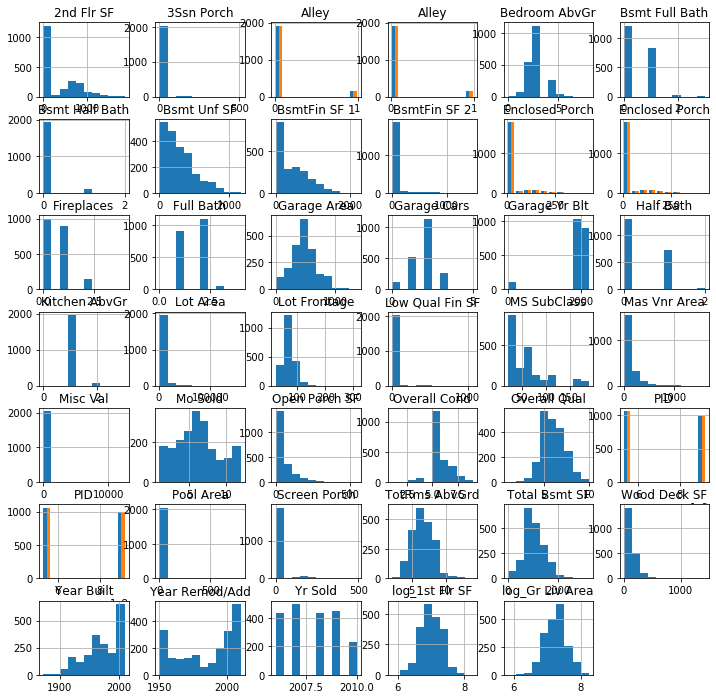

In [369]:
ames[predictors].hist(figsize = (12,12));

Annother function that is a work in progress below, this one deals with correlations between features. This has been commented out so it does not create an error in the final code. 

In [373]:
# def check_corr(predicton_list, df, corr_allowance):
#     list_high_correlation = []
#     count = 0
#     corr = df[predicton_list].corr()
#     large = corr[corr > corr_allowance]
#     for i in range(len(predicton_list)-1):
#         count += 1
#         data = large[(large[predicton_list[i]] < 1)][predicton_list[i]]
#         if data.empty:
#             pass
#         else:
# #            list_high_correlation.append(predicton_list[i], ' and ', data)
#            print(predicton_list[i], ' and ', data.index[0], ' is correlated highly at ', data[0])
# #            print(data)
#     return 

In [374]:
#check_corr(predictors,ames,.7)

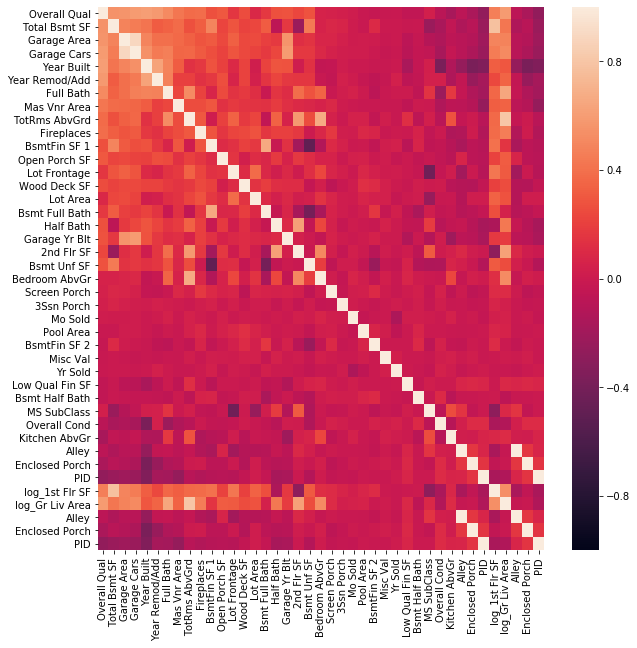

In [375]:
plt.figure(figsize = (10,10))
sns.heatmap(ames[predictors].corr(), vmin = -1, vmax = 1)

In [376]:
#Create dummy columns for 'Kitchen Qual' and 'Bsmt Qual'
ames = pd.get_dummies(ames, columns = ['Kitchen Qual'], drop_first=True)
ames = pd.get_dummies(ames, columns = ['Bsmt Qual'], drop_first=True)
ames.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,log_SalePrice,log_1st Flr SF,log_Gr Liv Area,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_TA,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Po,Bsmt Qual_TA
0,533352170,60,RL,75.0,13517,0,IR1,Lvl,AllPub,CulDSac,...,11.779129,6.586172,7.299121,0,1,0,0,0,0,1
1,531379050,60,RL,43.0,11492,0,IR1,Lvl,AllPub,CulDSac,...,12.301383,6.816736,7.660114,0,1,0,0,1,0,0
2,535304180,20,RL,68.0,7922,0,Reg,Lvl,AllPub,Inside,...,11.599103,6.963190,6.963190,0,1,0,0,0,0,1
3,916386060,60,RL,73.0,9802,0,Reg,Lvl,AllPub,Inside,...,12.066811,6.612041,7.275172,0,0,1,0,1,0,0
4,906425045,50,RL,82.0,14235,0,IR1,Lvl,AllPub,Inside,...,11.838626,6.722630,7.275865,0,0,1,1,0,0,0


In [377]:
object_features = list(ames.columns[-7:])

In [378]:
predictors = predictors + object_features

## ----------------------------------------------------------------------------------------------------------Cells below this point are included to show modeling workflow, a summary and much cleaner version of this section is included in the *project_2_modeling* notebook found in this repository ----------------------------------------------------------------------------------------------------------

## Create Features and Target

In [280]:
# set X to the predictors
X = ames[predictors]
y = ames['log_SalePrice']

## Train/Test Split

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

## Scale Data

In [60]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train) #learn the means and stds for each of the features
X_train_sc = ss.transform(X_train) # turned X_train into z-scores
X_test_sc = ss.transform(X_test) # turned X_test into z-scores

## Check for revised features list

In [61]:
#create a scaled df for heatmap
X_sc_df = pd.DataFrame(X_train_sc)
X_sc_df.columns = predictors
X_sc_df['SalePrice'] = y_train
X_sc_df.head(2)

,Overall Qual,Total Bsmt SF,Garage Area,Garage Cars,Year Built,Year Remod/Add,Full Bath,Mas Vnr Area,TotRms AbvGrd,Fireplaces,...,Enclosed Porch,PID,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_TA,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Po,Bsmt Qual_TA,SalePrice
0,0.645891,0.432525,0.525223,0.301722,0.138720,-0.387556,0.767658,0.233618,-0.904569,0.669102,...,-0.378667,-1.008118,-0.152702,1.222091,-1.018398,-0.175706,1.159758,-0.025524,-0.861102,11.779129
1,0.645891,0.026783,-0.141902,0.301722,0.105613,-0.434985,0.767658,-0.546672,-1.546332,0.669102,...,-0.378667,-1.007620,-0.152702,-0.818270,0.981934,-0.175706,1.159758,-0.025524,-0.861102,12.301383


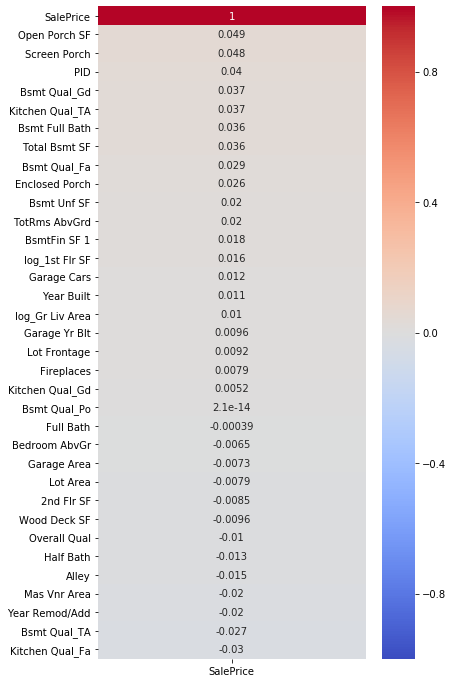

In [62]:
# heatmap based on target 'price' (y_train) to pick high correlation predictors FROM SCALED DATA

sc_price_corr = X_sc_df.corr()[['SalePrice']].sort_values(['SalePrice'],ascending = False)


plt.figure(figsize = (6,12))
sns.heatmap(sc_price_corr, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)

# Linear Regression

In [282]:
#instatiate model
model = LinearRegression()

In [283]:
#fit model
model.fit(X_train,y_train) #use scaled X_train_sc here for scaled data

#generate predictions
y_predict = model.predict(X_train) #use scaled X_train_sc here for scaled data

In [284]:
cross_val_score(model, X_train, y_train, cv=5).mean()

0.8927953327347721

In [285]:
model.score(X_train, y_train)

0.9045315128363336

In [286]:
model.score(X_test,y_test)

0.9021020719184097

In [287]:
y_predict[:5]

array([12.14997459, 11.84445275, 11.39639165, 11.43707317, 11.8679793 ])

In [288]:
#convert training prices back to standard form for scoring
y_train = np.exp(y_train)
y_predict = np.exp(y_predict)

In [289]:
np.sqrt(mean_squared_error(y_train,y_predict))

21219.360485874004

In [290]:
y_predict_test = model.predict(X_test)

In [292]:
#convert test prices back to standard form for scoring
y_test = np.exp(y_test)
y_predict_test = np.exp(y_predict_test)

In [293]:
np.sqrt(mean_squared_error(y_test,y_predict_test))

22894.777641928362

In [294]:
y_predict_test[:5]

array([340164.14542839, 210609.38648985,  99208.05283404, 293175.75741334,
       148446.61291769])

## LASSO Regression

In [74]:
#import LASSO regression model from sklearn
from sklearn.linear_model import Lasso, LassoCV

In [75]:
# Set up a list of LASSO alphas to check.
# Generates 100 values equally between -5 and 5,
# then converts them to alphas between 10^-5 and 10^5.
alphas_lasso = np.logspace(-5,5,100)

# Cross-validate over our list of ridge alphas.
lasso_cv = LassoCV(
    alphas = alphas_lasso,  #no need to designate score here
    cv = 5)

# Fit model using best ridge alpha!
lasso_cv.fit(X_train_sc, y_train)

LassoCV(alphas=array([1.00000000e-05, 1.26185688e-05, 1.59228279e-05, 2.00923300e-05,
       2.53536449e-05, 3.19926714e-05, 4.03701726e-05, 5.09413801e-05,
       6.42807312e-05, 8.11130831e-05, 1.02353102e-04, 1.29154967e-04,
       1.62975083e-04, 2.05651231e-04, 2.59502421e-04, 3.27454916e-04,
       4.13201240e-04, 5.21400829e-04, 6.57933225e-04, 8.30217568e-04,
       1.04761575e-03, 1.32194115e-0...
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [76]:
# Here is the optimal value of alpha
lasso_cv.alpha_

11.497569953977356

In [77]:
lasso_cv.score(X_train_sc, y_train)

0.8947281210258303

In [78]:
lasso_cv.score(X_test_sc, y_test)

0.8889674129534026

## Elastic Net Regression

### Create Features and Target

In [182]:
# set X to the predictors
X_all = ames.select_dtypes(exclude=['object'])
# set y target
y_all = ames['SalePrice']

In [183]:
#drop log values
X_all = X_all.drop(columns = ['PID','SalePrice','log_SalePrice', 'log_1st Flr SF', 'log_Gr Liv Area'])
X_all.head()

,MS SubClass,Lot Frontage,Lot Area,Alley,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,...,Misc Val,Mo Sold,Yr Sold,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_TA,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Po,Bsmt Qual_TA
0,60,75.0,13517,0,6,8,1976,2005,289.0,533.0,...,0,3,2010,0,1,0,0,0,0,1
1,60,43.0,11492,0,7,5,1996,1997,132.0,637.0,...,0,4,2009,0,1,0,0,1,0,0
2,20,68.0,7922,0,5,7,1953,2007,0.0,731.0,...,0,1,2010,0,1,0,0,0,0,1
3,60,73.0,9802,0,5,5,2006,2007,0.0,0.0,...,0,4,2010,0,0,1,0,1,0,0
4,50,82.0,14235,0,6,8,1900,1993,0.0,0.0,...,0,3,2010,0,0,1,1,0,0,0


In [207]:
abc = X_all.columns

## Train/Test Split

In [184]:
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(X_all, y_all, random_state=7)

<br>
Train Elastic net Regression model on all numerical features

In [185]:
#import ElasticNet CV from sklearn
from sklearn.linear_model import ElasticNetCV

In [186]:
# From lecture 4.05
# Set up a list of alphas to check.
enet_alphas = np.linspace(0.01, 1, 100)
# Set up our l1 ratio. 
#enet_ratio = np.linspace(0.01, 1, 100)
enet_ratio = .5
# Instantiate model.
enet_model = ElasticNetCV(alphas=enet_alphas,
                          l1_ratio=enet_ratio, cv=5)
# Fit model using optimal alpha.
enet_model = enet_model.fit(X_train_en, y_train_en)
# Generate predictions.
enet_model_preds_train = enet_model.predict(X_train_en)
enet_model_preds_test = enet_model.predict(X_test_en)

# Evaluate model.
print(enet_model.score(X_train_en, y_train_en))
print(enet_model.score(X_test_en, y_test_en))

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 475838957318.98914, tolerance: 761216603.0030218
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 475218612649.5787, tolerance: 761216603.0030218
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474593909975.95197, tolerance: 761216603.0030218
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401441146241.1669, tolerance: 761216603.0030218
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 399635132639.93066, tolerance: 761216603.0030218
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 397763984331.1105, tolerance: 761216603.0030218
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 452664801167.79913, tolerance: 748940666.5476592
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 451563499277.0767, tolerance: 748940666.5476592
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450444349218.61835, tolerance: 748940666.5476592
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464803130819.8013, tolerance: 756809727.9237628
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463775159082.3137, tolerance: 756809727.9237628
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 462734305837.1499, tolerance: 756809727.9237628
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_m

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508958637890.8792, tolerance: 767088162.4715918
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508127999235.93097, tolerance: 767088162.4715918
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 507290353235.47894, tolerance: 767088162.4715918
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508084962427.56635, tolerance: 781312665.7752466
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 507372211700.7321, tolerance: 781312665.7752466
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 506654015837.0513, tolerance: 781312665.7752466
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_

0.9053502220599142
0.8986275053685565


/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 382029186187.9479, tolerance: 781312665.7752466
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375401128460.2926, tolerance: 781312665.7752466
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367362155883.6528, tolerance: 781312665.7752466
  tol, rng, random, positive)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_m

In [187]:
# Here is the optimal value of alpha.
enet_model.alpha_

0.01

In [188]:
enet_model.l1_ratio_

0.5

In [189]:
#check mean prediction
enet_model_preds_test.mean()

185808.95184757817

In [190]:
ames['SalePrice'].mean()

181479.01805758907

In [191]:
np.sqrt(mean_squared_error(enet_model_preds_train,y_train_en))

24244.561083809986

In [192]:
np.sqrt(mean_squared_error(enet_model_preds_test,y_test_en))

25645.833945574752

In [193]:
print(enet_model.score(X_train_en, y_train_en))
print(enet_model.score(X_test_en, y_test_en))

0.9053502220599142
0.8986275053685565


In [194]:
enet_model_preds_test.mean()

185808.95184757817

## Export for Kaggle

In [295]:
test_data = pd.read_csv('datasets/test.csv')

In [296]:
test_data.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [297]:
#after reeading in the test data add the logarithmic fields
test_data['log_1st Flr SF'] = np.log(test_data['1st Flr SF'])
test_data['log_Gr Liv Area'] = np.log(test_data['Gr Liv Area'])

In [298]:
test_data.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,log_1st Flr SF,log_Gr Liv Area
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,6.811244,7.564238
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,8,2006,WD,7.584265,7.584265
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,9,2006,New,6.498282,7.310550
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,7,2007,WD,6.875232,6.875232
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,7,2009,WD,7.239933,7.239933


In [299]:
#add dummies
test_data = pd.get_dummies(test_data, columns = ['Kitchen Qual'], drop_first=True)
test_data = pd.get_dummies(test_data, columns = ['Bsmt Qual'], drop_first=True)
test_data.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,log_1st Flr SF,log_Gr Liv Area,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Po,Bsmt Qual_TA
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,6.811244,7.564238,1,0,0,0,1,0,0,0
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,7.584265,7.584265,0,0,0,1,0,1,0,0
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,6.498282,7.310550,0,1,0,0,0,1,0,0
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,6.875232,6.875232,0,0,0,1,0,0,0,1
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,7.239933,7.239933,0,0,0,1,0,1,0,0


In [300]:
#assign predictors
test_data_X = test_data[predictors]
test_data_X.isnull().sum()

Overall Qual         0
Total Bsmt SF        0
Garage Area          0
Garage Cars          0
Year Built           0
Year Remod/Add       0
Full Bath            0
Mas Vnr Area         1
TotRms AbvGrd        0
Fireplaces           0
BsmtFin SF 1         0
Open Porch SF        0
Lot Frontage       160
Wood Deck SF         0
Lot Area             0
Bsmt Full Bath       0
Half Bath            0
Garage Yr Blt       45
2nd Flr SF           0
Bsmt Unf SF          0
Bedroom AbvGr        0
Screen Porch         0
3Ssn Porch           0
Mo Sold              0
Pool Area            0
BsmtFin SF 2         0
Misc Val             0
Yr Sold              0
Low Qual Fin SF      0
Bsmt Half Bath       0
MS SubClass          0
Overall Cond         0
Kitchen AbvGr        0
Alley              820
Enclosed Porch       0
PID                  0
log_1st Flr SF       0
log_Gr Liv Area      0
Kitchen Qual_Fa      0
Kitchen Qual_Gd      0
Kitchen Qual_TA      0
Bsmt Qual_Fa         0
Bsmt Qual_Gd         0
Bsmt Qual_P

In [301]:
#remove null values for 'Mas Vnr Area'
test_data_X['Mas Vnr Area'].fillna(0,inplace = True)

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [302]:
test_data_X['Mas Vnr Area'].isnull().sum()

0

In [303]:
#remove null values for 'Garage Yr Built'
test_data_X['Garage Yr Blt'].fillna(0,inplace = True)

In [304]:
#remove null values for 'Lot Frontage'
test_data_X['Lot Frontage'].fillna(0,inplace = True)

In [305]:
test_data_X['Alley'].value_counts()

Grvl    35
Pave    23
Name: Alley, dtype: int64

In [306]:
# systematically replace 'Alley' values with 0 and any other value with 1
#iterate over the entrie df
for i in range(len(test_data_X)): 
#check to see if 'Alley' is null
    if pd.isnull(test_data_X.loc[i,'Alley']):
#if null replace with 0
        test_data_X.loc[i,'Alley'] = 0
#otherwise replace with 1
    else:
        test_data_X.loc[i,'Alley'] = 1

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [265]:
test_data_X.isnull().sum()

Overall Qual       0
Total Bsmt SF      0
Garage Area        0
Garage Cars        0
Year Built         0
Year Remod/Add     0
Full Bath          0
Mas Vnr Area       0
TotRms AbvGrd      0
Fireplaces         0
BsmtFin SF 1       0
Open Porch SF      0
Lot Frontage       0
Wood Deck SF       0
Lot Area           0
Bsmt Full Bath     0
Half Bath          0
Garage Yr Blt      0
2nd Flr SF         0
Bsmt Unf SF        0
Bedroom AbvGr      0
Screen Porch       0
3Ssn Porch         0
Mo Sold            0
Pool Area          0
BsmtFin SF 2       0
Misc Val           0
Yr Sold            0
Low Qual Fin SF    0
Bsmt Half Bath     0
MS SubClass        0
Overall Cond       0
Kitchen AbvGr      0
Alley              0
Enclosed Porch     0
PID                0
log_1st Flr SF     0
log_Gr Liv Area    0
Kitchen Qual_Fa    0
Kitchen Qual_Gd    0
Kitchen Qual_TA    0
Bsmt Qual_Fa       0
Bsmt Qual_Gd       0
Bsmt Qual_Po       0
Bsmt Qual_TA       0
dtype: int64

In [307]:
test_data_X.shape

(878, 45)

In [308]:
test_data_X.head()

,Overall Qual,Total Bsmt SF,Garage Area,Garage Cars,Year Built,Year Remod/Add,Full Bath,Mas Vnr Area,TotRms AbvGrd,Fireplaces,...,PID,log_1st Flr SF,log_Gr Liv Area,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_TA,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Po,Bsmt Qual_TA
0,6,1020,440,1,1910,1950,2,0.0,9,0,...,902301120,6.811244,7.564238,1,0,0,1,0,0,0
1,5,1967,580,2,1977,1977,2,0.0,10,0,...,905108090,7.584265,7.584265,0,0,1,0,1,0,0
2,7,654,426,2,2006,2006,2,0.0,7,1,...,528218130,6.498282,7.310550,0,1,0,0,1,0,0
3,5,968,480,2,1923,2006,1,0.0,5,0,...,902207150,6.875232,6.875232,0,0,1,0,0,0,1
4,6,1394,514,2,1963,1963,1,247.0,6,2,...,535105100,7.239933,7.239933,0,0,1,0,1,0,0


In [293]:
#scale the Kaggle testing data
test_data_Z = ss.transform(test_data_X) # turn test_data_X into z-scores

In [294]:
test_data_Z[:5, :5]

array([[-0.06223793, -0.06100903, -0.14190189, -0.99281712, -2.04631208],
       [-0.77036721,  2.1859966 ,  0.50221897,  0.30172201,  0.17182642],
       [ 0.64589136, -0.92943992, -0.20631397,  0.30172201,  1.13191621],
       [-0.77036721, -0.18439265,  0.04213265,  0.30172201, -1.615927  ],
       [-0.06223793,  0.82640397,  0.198562  ,  0.30172201, -0.29166521]])

### Linear Regression

In [309]:
lr_test_predict_y = model.predict(test_data_X) #predict using scaled data 'Z'

In [310]:
#convert the predictions back into standard form
lr_test_predict_y = np.exp(lr_test_predict_y)

In [311]:
lr_test_predict_y[:5]

array([136596.10748458, 146576.92458544, 200384.76603274, 109480.76721354,
       163855.2058497 ])

### LASSO

In [497]:
lasso_test_predict_y = lasso_cv.predict(test_data_Z) #predict using scaled data 'Z'

### Elastic Net

In [195]:
test_data_en = pd.read_csv('datasets/test.csv')

In [196]:
#add dummies
test_data_en = pd.get_dummies(test_data_en, columns = ['Kitchen Qual'], drop_first=True)
test_data_en = pd.get_dummies(test_data_en, columns = ['Bsmt Qual'], drop_first=True)
test_data_en.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Yr Sold,Sale Type,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Po,Bsmt Qual_TA
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,2006,WD,1,0,0,0,1,0,0,0
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,2006,WD,0,0,0,1,0,1,0,0
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,2006,New,0,1,0,0,0,1,0,0
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,2007,WD,0,0,0,1,0,0,0,1
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,2009,WD,0,0,0,1,0,1,0,0


In [197]:
# systematically replace 'Alley' values with 0 and any other value with 1
#iterate over the entrie df
for i in range(len(test_data_en)): 
#check to see if 'Alley' is null
    if pd.isnull(test_data_en.loc[i,'Alley']):
#if null replace with 0
        test_data_en.loc[i,'Alley'] = 0
#otherwise replace with 1
    else:
        test_data_en.loc[i,'Alley'] = 1

In [213]:
#assign predictors (all numerical columns for Elastic Net)
test_data_X_en = test_data_en[abc]

In [214]:
test_data_X_en.isnull().sum()

MS SubClass          0
Lot Frontage       160
Lot Area             0
Alley                0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Mas Vnr Area         1
BsmtFin SF 1         0
BsmtFin SF 2         0
Bsmt Unf SF          0
Total Bsmt SF        0
1st Flr SF           0
2nd Flr SF           0
Low Qual Fin SF      0
Gr Liv Area          0
Bsmt Full Bath       0
Bsmt Half Bath       0
Full Bath            0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
TotRms AbvGrd        0
Fireplaces           0
Garage Yr Blt       45
Garage Cars          0
Garage Area          0
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
Mo Sold              0
Yr Sold              0
Kitchen Qual_Fa      0
Kitchen Qual_Gd      0
Kitchen Qual_TA      0
Bsmt Qual_Fa         0
Bsmt Qual_Gd         0
Bsmt Qual_Po         0
Bsmt Qual_T

In [215]:
#remove null values for 'Mas Vnr Area'
test_data_X_en['Mas Vnr Area'].fillna(0,inplace = True)

#remove null values for 'Garage Yr Built'
test_data_X_en['Garage Yr Blt'].fillna(0,inplace = True)

#remove null values for 'Lot Frontage'
test_data_X_en['Lot Frontage'].fillna(0,inplace = True)

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [216]:
test_data_X_en.isnull().sum().sum()

0

In [218]:
len(test_data_X_en.columns)

44

In [219]:
len(abc)

44

In [220]:
#create predictions
elastic_test_predict_y = enet_model.predict(test_data_X_en)

In [223]:
elastic_test_predict_y.mean()

179439.87303601025

In [224]:
elastic_test_predict_y[:5]

array([162884.66055364, 149030.63854904, 202641.96364453, 109267.58805488,
       181927.69054482])

### Create Submission DF

In [312]:
submission = pd.DataFrame()

In [313]:
submission['Id'] = test_data_en['Id']

#### Specify Regression Model here

In [314]:
submission['SalePrice'] = lr_test_predict_y #elastic_test_predict_y, lasso_test_predict_y

In [315]:
submission.head()

,Id,SalePrice
0,2658,136596.107485
1,2718,146576.924585
2,2414,200384.766033
3,1989,109480.767214
4,625,163855.205850


In [316]:
submission.to_csv('Submissions/attempt11.csv',index=False)

### Feature Count / Check

In [317]:
#current feature count
print(f'Current features: {len(predictors)}')
#Maximum allowable features
print(f'Maximum allowable features: {int(np.sqrt(len(ames)))}')

Current features: 45
Maximum allowable features: 45
